# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:** Построение модели, которая по фотографии определит приблизительный возраст покупателя.

**Описание данных:** Папка с изображениями покупателей и CSV-файл с реальными значениями их возрастов.

**План работы:**

1) Исследовательский анализ данных

2) Обучение модели

3) Анализ обученной модели

## Исследовательский анализ данных

Загрузим необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Извлечем данные из папки:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Выведем датасет на экран:

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Выведем на экран информацию о датасете:

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Посмотрим на размер выборки:

In [5]:
labels.shape

(7591, 2)

Построим гистограмму распределения возраста в выборке:

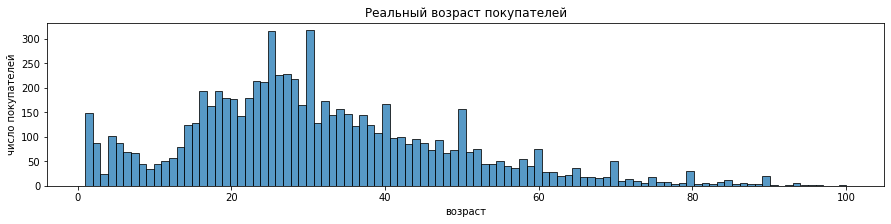

In [19]:
plt.figure(figsize=(15,3))
sns.histplot(labels['real_age'], bins=100).set(title='Реальный возраст покупателей')

plt.xlabel('возраст')
plt.ylabel('число покупателей')
plt.show()

Выделим признаки и целевой признак:

In [20]:
features, target = next(train_gen_flow)

Напечатаем на экране пятнадцать фотографий из датасета:

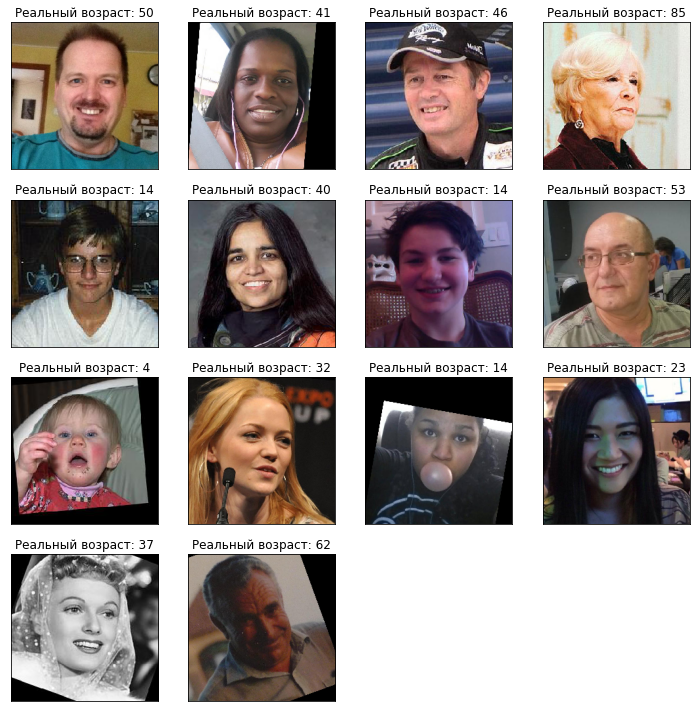

In [34]:
fig = plt.figure(figsize=(10,10))
for i in range(0, 14):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Реальный возраст: {target[i]}")
    plt.tight_layout()

**Вывод:** Датасет состоит из 7591-ой фотографии. Пиковые значения возраста фотографируемых приходятся на 25 и 30 лет. Фотографии весьма разнообразны: на них встречаются закрывающие часть лица предметы, некоторые лица повернуты в сторону, также присутствуют перекосы и "темные зоны". Сложность обучения модели на основе данного датасета можно оценить, как среднюю.

## Обучение модели

Перенесем из GPU-тренажера код обучения модели:

```python

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, vertical_flip=True, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='relu'))

    model.compile(optimizer=Adam(lr=0.0001),          
                  loss='mean_squared_error', metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Перенесем результат вывода на экран:

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 67s - loss: 320.8507 - mae: 13.0873 - val_loss: 988.4520 - val_mae: 26.7115
Epoch 2/5
178/178 - 39s - loss: 112.5008 - mae: 7.9981 - val_loss: 399.8541 - val_mae: 15.0959
Epoch 3/5
178/178 - 39s - loss: 80.8295 - mae: 6.8476 - val_loss: 218.3701 - val_mae: 10.9383
Epoch 4/5
178/178 - 39s - loss: 68.3783 - mae: 6.2604 - val_loss: 136.4696 - val_mae: 8.8904
Epoch 5/5
178/178 - 38s - loss: 54.5830 - mae: 5.5903 - val_loss: 104.8365 - val_mae: 7.6317
60/60 - 10s - loss: 104.8365 - mae: 7.6317
Test MAE: 7.6317

```

**Вывод:** В результате обучения модели значение метрики MAE составило 7.63, что соответсвует задаче проекта.

## Анализ обученной модели

В проекте использован датасет, состоящий из 7591-ой фотографии. Пиковые значения возраста фотографируемых приходятся на 25 и 30 лет. Фотографии весьма разнообразны: на них встречаются закрывающие часть лица предметы, некоторые лица повернуты в сторону, также присутствуют перекосы и "темные зоны".

В результате обучения модели значение метрики MAE составило 7.63, следовательно, при предсказании возраста покупателей погрешность не превысит восемь лет, что соответсвует задаче проекта.

Такие результаты, в целом, позволят супермаркету "Хлеб-Соль" выполнять первую поставленную задачу: анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы. Со второй задачей - контроль добросовестности кассиров при продаже алкоголя - дела обстоят немного сложнее: с учетом возможной погрешности в минус, довериться предсказаниям модели можно будет только для покупателей от 26-ти лет; а до этого возраста продавцам придется проверять документы вообще у всех.